INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkpi168ab/e_ue18k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkpi168ab/07b_duck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62669', 'data', 'file=/tmp/tmpkpi168ab/e_ue18k1.json', 'init=/tmp/tmpkpi168ab/07b_duck.json', 'output', 'file=/tmp/tmpkpi168ab/prophet_model8lxd8xwq/prophet_model-20231116032800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:28:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:28:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


31/31 [==============================] - 0s 2ms/step


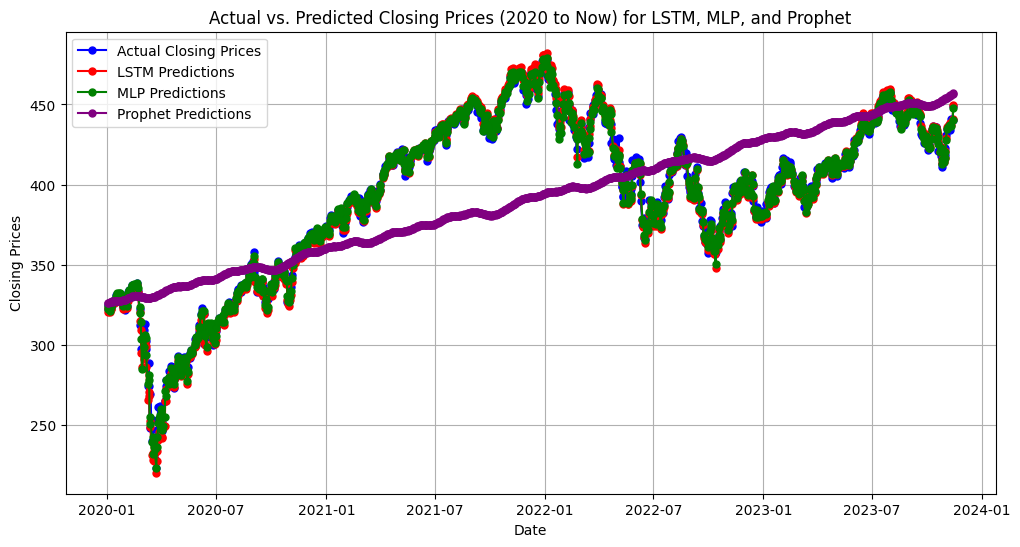

In [47]:
import pandas as pd
from prophet import Prophet
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


df = pd.read_csv('SPYhist.csv')


df['Date'] = pd.to_datetime(df['Date'])


df_prophet = df[['Date', 'Close']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})


model_prophet = Prophet()
model_prophet.fit(df_prophet)


X = df[['Volume', 'Open', 'Low']].values
y = df['Close'].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_scaled.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


lstm_model.fit(X_lstm, y, epochs=50, batch_size=64, verbose=0)


mlp_model = Sequential()
mlp_model.add(Dense(50, activation='relu', input_dim=X_scaled.shape[1]))
mlp_model.add(Dense(1))
mlp_model.compile(optimizer='adam', loss='mean_squared_error')


mlp_model.fit(X_scaled, y, epochs=50, batch_size=64, verbose=0)


start_date = pd.to_datetime('2020-01-01')
filtered_df = df[df['Date'] >= start_date]


X_filtered = filtered_df[['Volume', 'Open', 'Low']].values
X_filtered_scaled = scaler.transform(X_filtered)
X_filtered_lstm = X_filtered_scaled.reshape(X_filtered_scaled.shape[0], 1, X_filtered_scaled.shape[1])

lstm_filtered_predictions = lstm_model.predict(X_filtered_lstm).flatten()
mlp_filtered_predictions = mlp_model.predict(X_filtered_scaled).flatten()
actuals_filtered = filtered_df['Close'].values


df_prophet_filtered = df_prophet[df_prophet['ds'] >= start_date]
forecast_filtered = model_prophet.predict(df_prophet_filtered)


actuals_prophet_filtered = df_prophet[df_prophet['ds'].isin(filtered_df['Date'])]


plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], actuals_filtered, label='Actual Closing Prices', color='blue', marker='o', markersize=5)
plt.plot(filtered_df['Date'], lstm_filtered_predictions, label='LSTM Predictions', color='red', marker='o', markersize=5)
plt.plot(filtered_df['Date'], mlp_filtered_predictions, label='MLP Predictions', color='green', marker='o', markersize=5)
plt.plot(actuals_prophet_filtered['ds'], forecast_filtered['yhat'], label='Prophet Predictions', color='purple', marker='o', markersize=5)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Actual vs. Predicted Closing Prices (2020 to Now) for LSTM, MLP, and Prophet')
plt.legend()
plt.grid(True)
plt.show()


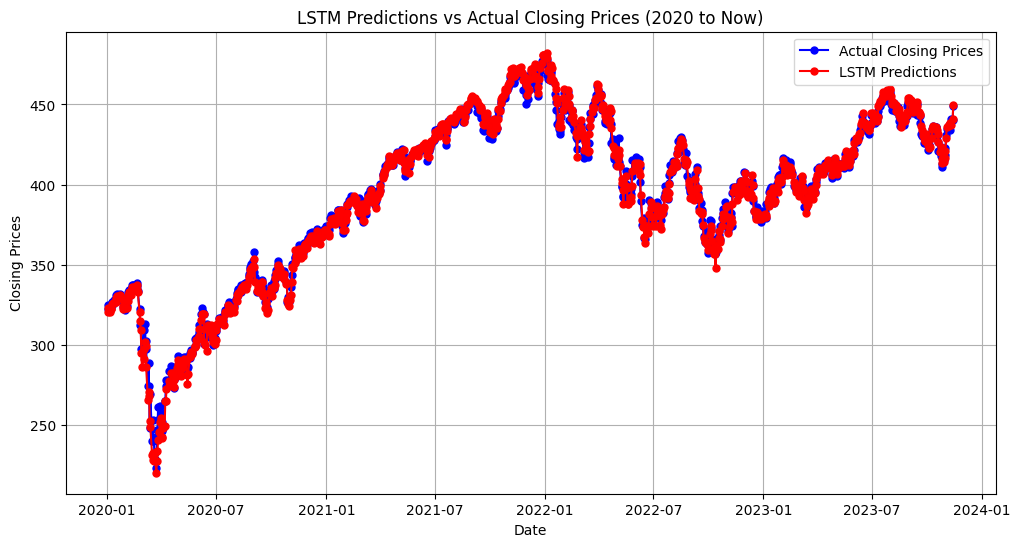

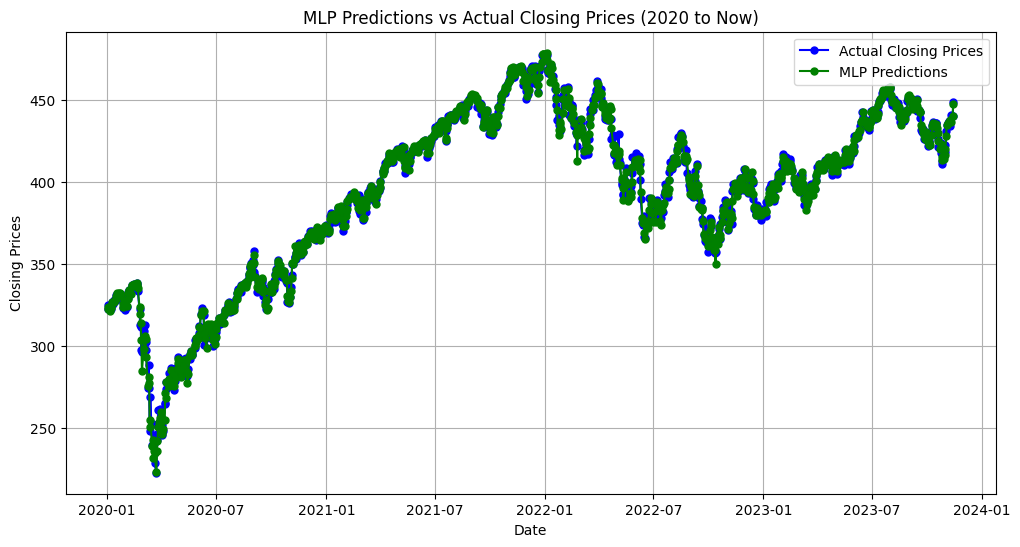

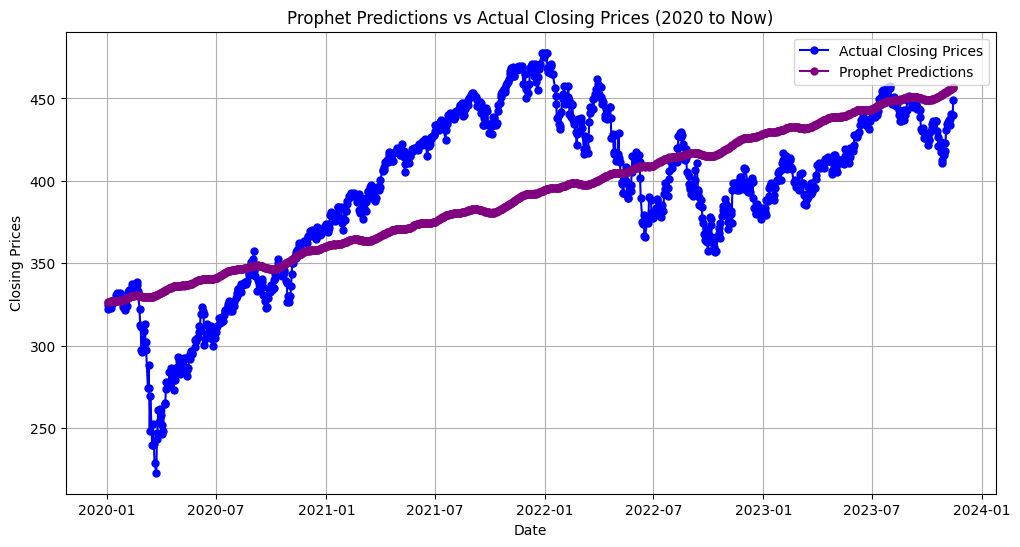

In [48]:

actuals_prophet_filtered = df_prophet[df_prophet['ds'].isin(filtered_df['Date'])]


plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], actuals_filtered, label='Actual Closing Prices', color='blue', marker='o', markersize=5)
plt.plot(filtered_df['Date'], lstm_filtered_predictions, label='LSTM Predictions', color='red', marker='o', markersize=5)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('LSTM Predictions vs Actual Closing Prices (2020 to Now)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], actuals_filtered, label='Actual Closing Prices', color='blue', marker='o', markersize=5)
plt.plot(filtered_df['Date'], mlp_filtered_predictions, label='MLP Predictions', color='green', marker='o', markersize=5)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('MLP Predictions vs Actual Closing Prices (2020 to Now)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(actuals_prophet_filtered['ds'], actuals_prophet_filtered['y'], label='Actual Closing Prices', color='blue', marker='o', markersize=5)
plt.plot(actuals_prophet_filtered['ds'], forecast_filtered['yhat'], label='Prophet Predictions', color='purple', marker='o', markersize=5)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Prophet Predictions vs Actual Closing Prices (2020 to Now)')
plt.legend()
plt.grid(True)
plt.show()


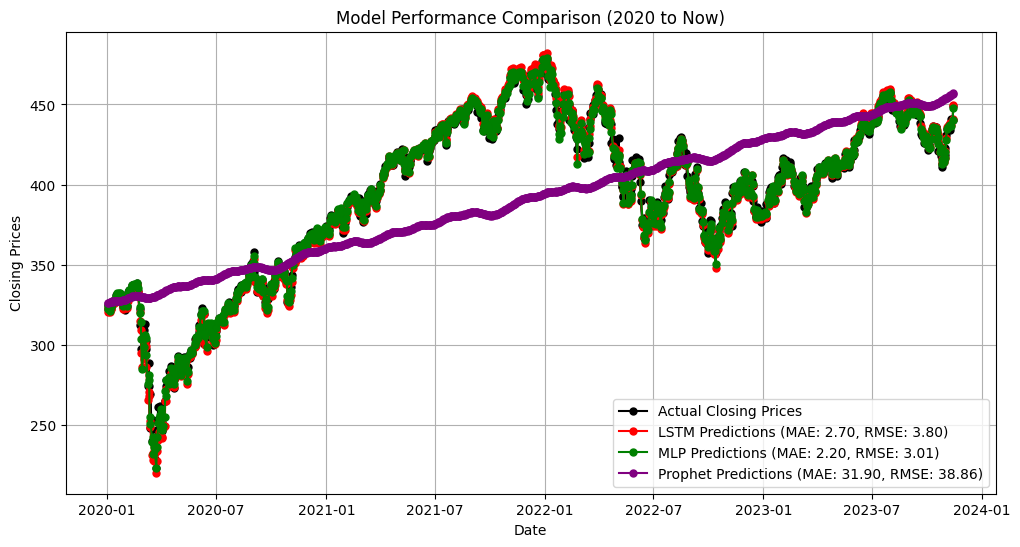

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


lstm_mae = mean_absolute_error(actuals_filtered, lstm_filtered_predictions)
lstm_rmse = np.sqrt(mean_squared_error(actuals_filtered, lstm_filtered_predictions))

mlp_mae = mean_absolute_error(actuals_filtered, mlp_filtered_predictions)
mlp_rmse = np.sqrt(mean_squared_error(actuals_filtered, mlp_filtered_predictions))

prophet_mae = mean_absolute_error(actuals_prophet_filtered['y'], forecast_filtered.loc[forecast_filtered['ds'].isin(filtered_df['Date']), 'yhat'])
prophet_rmse = np.sqrt(mean_squared_error(actuals_prophet_filtered['y'], forecast_filtered.loc[forecast_filtered['ds'].isin(filtered_df['Date']), 'yhat']))


plt.figure(figsize=(12, 6))


plt.plot(filtered_df['Date'], actuals_filtered, label='Actual Closing Prices', color='black', marker='o', markersize=5)


plt.plot(filtered_df['Date'], lstm_filtered_predictions, label=f'LSTM Predictions (MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f})', color='red', marker='o', markersize=5)


plt.plot(filtered_df['Date'], mlp_filtered_predictions, label=f'MLP Predictions (MAE: {mlp_mae:.2f}, RMSE: {mlp_rmse:.2f})', color='green', marker='o', markersize=5)


plt.plot(actuals_prophet_filtered['ds'], forecast_filtered['yhat'], label=f'Prophet Predictions (MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f})', color='purple', marker='o', markersize=5)

plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Model Performance Comparison (2020 to Now)')
plt.legend()
plt.grid(True)
plt.show()


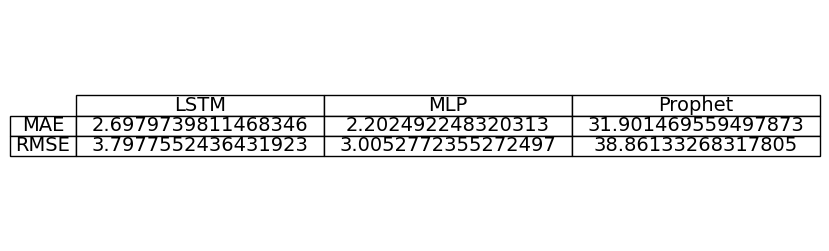

In [50]:
import matplotlib.pyplot as plt


metrics = {
    'Model': ['LSTM', 'MLP', 'Prophet'],
    'MAE': [lstm_mae, mlp_mae, prophet_mae],
    'RMSE': [lstm_rmse, mlp_rmse, prophet_rmse]
}


fig, ax = plt.subplots(figsize=(8, 3))


ax.axis('tight')
ax.axis('off')


table = ax.table(cellText=[metrics['MAE'], metrics['RMSE']],
                 rowLabels=['MAE', 'RMSE'],
                 colLabels=metrics['Model'],
                 cellLoc='center', rowLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)

plt.show()
